In [1]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv("conversion_project.csv")
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [21]:
data['converted'].value_counts()

0    306000
1     10198
Name: converted, dtype: int64

In [12]:
data.loc[data.age>=100,:]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [3]:
data = data.loc[data.age <100,:]

In [14]:
convert_by_country_dist = data.groupby("country")["converted"].mean()
convert_by_country_dist

country
China      0.001332
Germany    0.062428
UK         0.052612
US         0.037801
Name: converted, dtype: float64

<AxesSubplot:xlabel='country'>

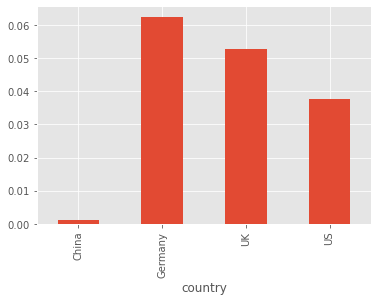

In [15]:
convert_by_country_dist.plot(kind="bar")

Chinese convert at a much lower rate than other countries

<AxesSubplot:xlabel='total_pages_visited'>

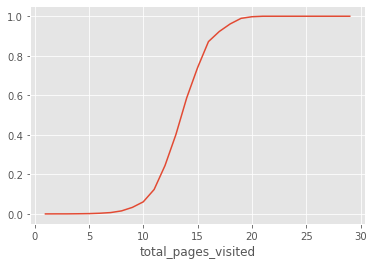

In [17]:
convert_by_pagevisit = data.groupby("total_pages_visited")['converted'].mean()
convert_by_pagevisit.plot(kind = "line")

Spending more time on the site implies higher probability of conversion

In [4]:
#dummy variables for the categorical ones
data_dummy = pd.get_dummies(data, drop_first=True)

Create test/training set with a standard 66% split (if the data were too small, I would cross-validate). Then, I build the forest with standard values for the 3 important parameters (100 trees, trees as large as possible, 3 random variables selected at each split).

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

The out-of-bag (OOB) error is the average error for each calculated using predictions from the trees that do not contain in their respective bootstrap sample

In [6]:
train, test = train_test_split(data_dummy, test_size = 0.34)
  
#build the model
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('converted', axis=1), train['converted'])
print("OOB accuracy is", rf.oob_score_, "\n", "OOB Confusion Matrix", "\n",pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.9839522737074129 
 OOB Confusion Matrix 
         0     1
0  200836  1139
1    2211  4504


In [23]:
print("Test accuracy is", rf.score(test.drop('converted', axis=1),test['converted']), "\n", 
"Test set confusion matrix", "\n",pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop('converted', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.9846895114782156 
 Test set confusion matrix 
         0     1
0  103549   542
1    1104  2313


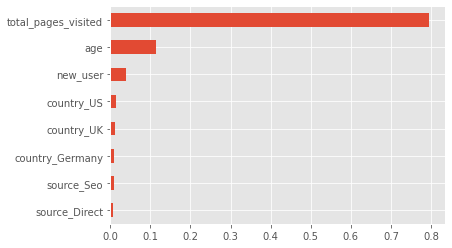

In [24]:
feat_importances = pd.Series(rf.feature_importances_, index=train.drop('converted', axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

Total pages visited is the most important one, by far. Unfortunately, it is probably the least “actionable”. People visit many pages because they already want to buy. Also, in order to buy, you have to click on multiple pages. Let’s rebuild the RF without that variable. Since classes are heavily unbalanced and we don’t have that very powerful variable anymore, let’s change the weights, just to make sure we will get something classified as 1.

In [28]:
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True, class_weight= "balanced")
rf.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])


print("OOB accuracy is", rf.oob_score_, "\n", "OOB confusion matrix", "\n",pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1])))

OOB accuracy is 0.7383487469452298 
 OOB confusion matrix 
         0      1
0  149124  52785
1    1819   4962


In [7]:
#try different weights
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True, class_weight= {0:1, 1:10})
rf.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])
print("OOB accuracy is", rf.oob_score_, "\n", "OOB confusion matrix", "\n",pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1])))

OOB accuracy is 0.8955867554746274 
 OOB confusion matrix 
         0      1
0  184006  17969
1    3821   2894


In [8]:
print("Test accuracy is", rf.score(test.drop(['converted', 'total_pages_visited'], axis=1),test['converted']), "\n", 
"Test Set Confusion Matrix", "\n",pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop(['converted', 'total_pages_visited'], axis=1)), labels=[0, 1]))
)

Test accuracy is 0.8945845890538379 
 Test Set Confusion Matrix 
        0     1
0  94666  9359
1   1974  1509


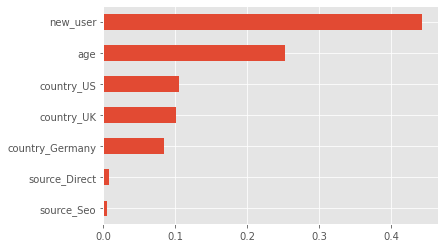

In [31]:
feat_importances = pd.Series(rf.feature_importances_, index=train.drop(['converted', 'total_pages_visited'], axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

 New user is the most important one, even more important than age. 

For the pdp module installation, I tried a lot. First, we need to have the vs C++ build tools installed. Then ,the simple
pip install pdp does not work due to the inconsistency of pdp and matplotlib. This one final works(https://anaconda.org/conda-forge/pdpbox):<p>
conda install -c conda-forge pdpbox<p>
conda install -c conda-forge/label/cf202003 pdpbox<p>
and if there is still error, we need pip uninstall matplotlib <p>
then conda install matplotlib


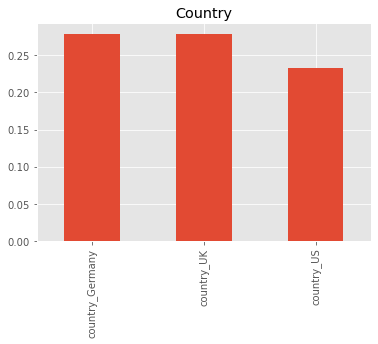

In [18]:
from pdpbox import pdp, info_plots
  
#country
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['country_Germany', 'country_UK', 'country_US'], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Country')
plt.show()

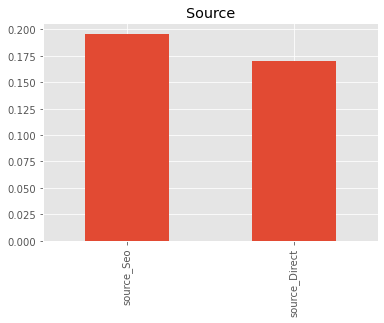

In [20]:
#source
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['source_Direct', 'source_Seo'], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Source')
plt.show()


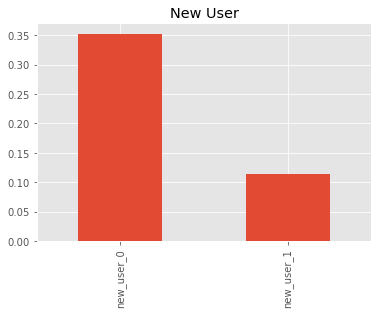

In [21]:
#new user
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='new_user', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='New User')
plt.show()

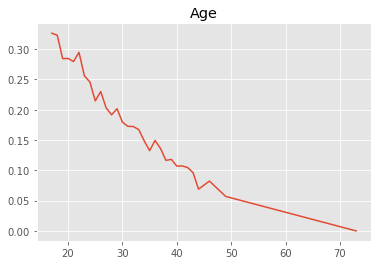

In [22]:
#age
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='age', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Age')
plt.show()

Users with an old account are much better than new users<p>
Germany, UK, and US are similar,  Germany is the best, as relative to the reference level China. So this means that not being from China and being from any of those 3 countries significantly increases the probability of conversion. <p>

The site works very well for young people and gets worse for >30 yr old <p>

Source is irrelevant<p>

Build a simple decision tree and check the 2 or 3 most important segments

In [23]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
  
tree = DecisionTreeClassifier( max_depth=2,class_weight={0:1, 1:10}, min_impurity_decrease = 0.001)
tree.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])
  
#visualize it
export_graphviz(tree, out_file="tree_conversion.dot", feature_names=train.drop(['converted', 'total_pages_visited'], axis=1).columns, proportion=True, rotate=True)
with open("tree_conversion.dot") as f:
    dot_graph = f.read()
s = Source.from_file("tree_conversion.dot")
s.view()

'tree_conversion.dot.pdf'

Conclusions and next steps:

The site is working very well for young users. Definitely let’s tell marketing to advertise and use channels which are more likely to reach young people.

The site is working very well for Germany in terms of conversion. But the summary showed that there are few Germans coming to the site: way less than UK, despite a larger population. Again, marketing should get more Germans. Big opportunity.

Users with old accounts do much better. Targeted emails with offers to bring them back to the site could be a good idea to try.

Maybe go through the UI and figure out why older users perform so poorly? From ~30 y/o conversion clearly starts dropping. A good actionable metric here is conversion rate for people >=30 yr old. Building a team whose goal is to increase that number would be interesting.

Something is wrong with the Chinese version of the site. It is either poorly translated, doesn’t fit the local culture, or maybe some payment issue. Given how many users are based in China, fixing this should be a top priority. Huge opportunity.

If someone has visited many pages, but hasn't converted, he almost surely has high purchase intent. could email him or sending reminders.

As you can see, product ideas usually end up being about:

Identify segments that perform well, but have low absolute count (like Germany). Then tell marketing to get more of those people

Tell product to fix the experience for the bad performing ones

Bad performing segments with high absolute count (like China) usually provide the biggest opportunities for massive gains, if you can guess why that’s happening and then build a test to validate your hypothesis